# Dataset Information

| Variable Name | Role    | Type    | Missing Values |
|---------------|---------|---------|----------------|
| win           | Target  | Binary  | no             |
| clusterid     | ID      | Integer | no             |
| gamemode      | Feature | Integer | no             |
| gametype      | Feature | Integer | no             |
| hero1         | Feature | Binary  | no             |
| hero2         | Feature | Binary  | no             |
| hero3         | Feature | Binary  | no             |
| hero4         | Feature | Binary  | no             |
| hero5         | Feature | Binary  | no             |
| hero_n         | Feature | Binary  | no             |

win = 1, loss = -1  
heroes: 1 = team 1, -1 = team 2

hero1 - hero_n is the id of the hero that a player has chosen. A function has been used to populate these heroes with the correct names.
Looking into the dataset, it seems that hero of id 24 is **missing**, so column 28 will be removed.

# Changelog

All events under a date follow in chronological order.

## 17/01/2024 
- Start work on naive bayesian classifier. 
- Using a Dota 2 dataset with 102k instances. 
- Dataset source: https://archive.ics.uci.edu/dataset/367/dota2+games+results
- Wrote simple function to extract hero information for header, source is here: https://github.com/kronusme/dota2-api/blob/master/data/heroes.json
- Examine performance of different Naive-Bayes classifiers, such as Gaussian and Bernoulli. Decide to experiment more with Bernoulli NB.
- Perform one-hot encoding on many features in the dataset.
- Improve accuracy from ~51% to 60% after one-hot encoding. 

The following code is used to extract the names of heroes from a JSON file to be used inside the header. This function will construct the full header string which can then be used when creating the Pandas DataFrame.

In [211]:

import json

def extract_hero_data() -> str:
    with open('data/heroes.json') as f:
        data = json.load(f)
        data = data['heroes']
        
    base_header = 'win,clusterid,gamemode,gametype'
    header_string = base_header
    for hero in data:
            header_string = f'{header_string},{hero["name"]}'

    return header_string

header_string = extract_hero_data()
print(header_string)
    
        



win,clusterid,gamemode,gametype,antimage,axe,bane,bloodseeker,crystal_maiden,drow_ranger,earthshaker,juggernaut,mirana,nevermore,morphling,phantom_lancer,puck,pudge,razor,sand_king,storm_spirit,sven,tiny,vengefulspirit,windrunner,zuus,kunkka,lina,lich,lion,shadow_shaman,slardar,tidehunter,witch_doctor,riki,enigma,tinker,sniper,necrolyte,warlock,beastmaster,queenofpain,venomancer,faceless_void,skeleton_king,death_prophet,phantom_assassin,pugna,templar_assassin,viper,luna,dragon_knight,dazzle,rattletrap,leshrac,furion,life_stealer,dark_seer,clinkz,omniknight,enchantress,huskar,night_stalker,broodmother,bounty_hunter,weaver,jakiro,batrider,chen,spectre,doom_bringer,ancient_apparition,ursa,spirit_breaker,gyrocopter,alchemist,invoker,silencer,obsidian_destroyer,lycan,brewmaster,shadow_demon,lone_druid,chaos_knight,meepo,treant,ogre_magi,undying,rubick,disruptor,nyx_assassin,naga_siren,keeper_of_the_light,wisp,visage,slark,medusa,troll_warlord,centaur,magnataur,shredder,bristleback,tusk,skyw

The following code loads the training data into a Pandas DataFrame and then assigns each column their respective header.

In [212]:
import pandas as pd

def load_data(header: str, dataset_path: str) -> pd.DataFrame:
    df = pd.read_csv(dataset_path)
    df = df.drop(df.columns[28], axis=1) # drop column 28 since hero id 24 is missing in heroes json file. We know hero 24 is on column 28 since hero one starts at column 5.
    header_list = header.split(',')
    df.columns = header_list
    df = df.drop('clusterid', axis=1)
    return df

df = load_data(header_string, 'data/dota2Train.csv')
df.head()

,win,gamemode,gametype,antimage,axe,bane,bloodseeker,crystal_maiden,drow_ranger,earthshaker,...,legion_commander,ember_spirit,earth_spirit,abyssal_underlord,terrorblade,phoenix,techies,oracle,winter_wyvern,arc_warden
0,1,2,2,0,0,0,1,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,2,0,0,0,1,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,2,0,0,0,0,0,0,-1,...,-1,0,0,0,0,0,0,0,0,0
3,-1,2,3,0,0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2,3,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-1


Plotting wins vs. losses to see if it is biased in any way. It seems reasonably even.

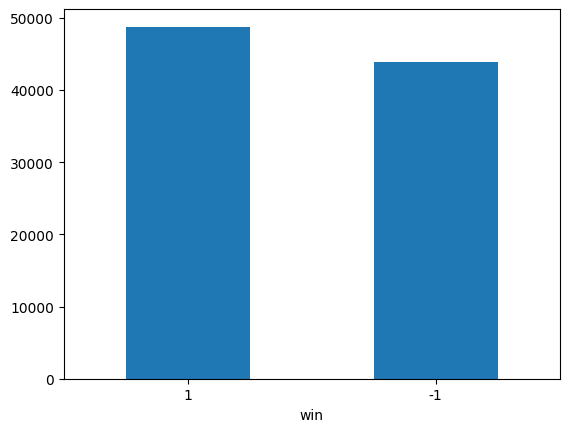

In [213]:
import matplotlib.pyplot as plt

def plot_team_wins():
    df['win'].value_counts().plot(kind='bar')
    plt.xticks(rotation=0)
    plt.show()

plot_team_wins()

Which Naive-Bayes (NB) model to use is a crucially important consideration. I am thinking about using One-Hot encoding to allow for the use of the Bernoulli NB model instead of a different model such as the Gaussian NB model. We can perform hot-one encoding easily with Pandas by using the pd.get_dummies() function. It is also best to specifically say whether a hero was a part of team 1 or team 2. This can be done by changing it from hero1 to hero1_team1 and hero1_team2 as a binary flag.

In [214]:
# count number of distinct gamemodes and gametypes
def count_gamemodes_and_types():
    gamemodes = df['gamemode'].value_counts()
    gametypes = df['gametype'].value_counts()
    return gamemodes, gametypes

def heroes_to_team1_team2(df):
    heroes = [col for col in df.columns if col not in ['win', 'gamemode', 'gametype']]
    team1_cols = {f'{hero}_team1': (df[hero] == 1).astype(int) for hero in heroes}
    team2_cols = {f'{hero}_team2': (df[hero] == -1).astype(int) for hero in heroes}

    df = df.drop(columns=heroes)
    df = pd.concat([df, pd.DataFrame(team1_cols), pd.DataFrame(team2_cols)], axis=1)
    return df

def wins_to_win_team1_team2(df):
    df['win_team1'] = (df['win'] == 1).astype(int)
    df['win_team2'] = (df['win'] == -1).astype(int)

    df = df.drop(columns=['win'])
    return df

# Run this LAST
def one_hot_encode_gamemodes_gametypes(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.get_dummies(df, columns=['gamemode', 'gametype'], dtype=int)
    return df

def prepare_data(df):
    df = heroes_to_team1_team2(df)
    df = wins_to_win_team1_team2(df)
    df = one_hot_encode_gamemodes_gametypes(df)
    return df

# gamemodes, gametypes = count_gamemodes_and_types()
# print(gamemodes)
# print(gametypes)

df = prepare_data(df)

df.head()

,antimage_team1,axe_team1,bane_team1,bloodseeker_team1,crystal_maiden_team1,drow_ranger_team1,earthshaker_team1,juggernaut_team1,mirana_team1,nevermore_team1,...,gamemode_3,gamemode_4,gamemode_5,gamemode_6,gamemode_7,gamemode_8,gamemode_9,gametype_1,gametype_2,gametype_3
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [215]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

y = df['win_team2']
X = df.drop(['win_team1','win_team2'], axis=1)

param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
grid_search = GridSearchCV(BernoulliNB(), param_grid, cv=5, scoring='accuracy') # Use cross-validation
grid_search.fit(X, y)

model = grid_search.best_estimator_
print("Best alpha:", grid_search.best_params_)


Best alpha: {'alpha': 0.001}


In [216]:
y_pred_train = model.predict(X)
print("Training Accuracy:", accuracy_score(y, y_pred_train))
print("\nTraining Classification Report:\n", classification_report(y, y_pred_train))

Training Accuracy: 0.6015175555051863

Training Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.68      0.64     48782
           1       0.59      0.52      0.55     43867

    accuracy                           0.60     92649
   macro avg       0.60      0.60      0.60     92649
weighted avg       0.60      0.60      0.60     92649



In [ ]:
test_df = load_data(header_string, 'data/dota2Test.csv')
test_df = prepare_data(test_df)

y = test_df['win_team1']
X = test_df.drop(['win_team1', 'win_team2'], axis=1)

y_pred_test = model.predict(X)
print("Training Accuracy:", accuracy_score(y, y_pred_test))
print("\nTraining Classification Report:\n", classification_report(y, y_pred_test))
